# Ejemplo árboles de decisión
Este ejemplo ilustra el uso de la librería Sickit-learn para árboles de decisión, y algunas funciones útiles para hacer una inspección inicial del conjunto de datos a trabajar. El ejemplo se ha construido para el curso de inteligencia artíficial de la Universidad del Magdalena. El conjunto de datos tomado como ejemplo es: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree

import warnings

Cargando el conjunto de datos de un archivo extensión .cvs, y mostrando información del archivo.

In [13]:
#Cargando datos
diabetes = pd.read_csv("./diabetes.csv")
#Informacion de los datos
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [14]:
#Resumen de estadísticos
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Visualizando la distribución de las clases a través de un histograma.

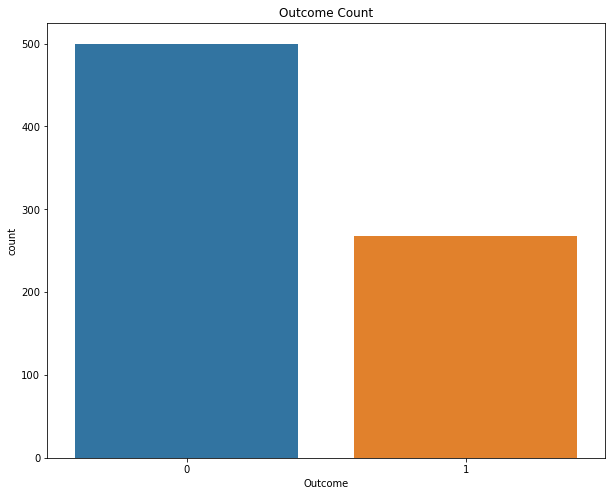

In [15]:
#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Outcome',data=diabetes)
plt.title("Outcome Count")
plt.show()

Algunas variables como Glucose, BloodPressure, SkinThickness, Insulin, BMI tienen valores de 0, lo cual no tiene sentido, en los foros de discusión en Kaggle se encuentra que el 0 en estas variables corresponden a valores faltantes.

In [16]:
#asignando nan a los ceros contenidos en las variables que no deberían tener 0, 
#asumiendo que el cero representa valores faltantes
cols = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness']
diabetes[cols] = diabetes[cols].replace({0:np.nan})


In [17]:
def missing_removal(df, confirm= None):
    holder= {}
    for col in df.columns:
        count = df[col].isnull().sum() 
        holder[col]= count
    return holder

In [18]:
print(missing_removal(diabetes, 0.5))
diabetes.shape[0]

{'Pregnancies': 0, 'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11, 'DiabetesPedigreeFunction': 0, 'Age': 0, 'Outcome': 0}


768

In [19]:
def fillna_mean_class(df, att, clase):
   mean_val = diabetes.groupby(clase)[att].mean() 
   df.loc[df[clase] == 0 & df[att].isnull(), att] = mean_val[0]
   df.loc[df[clase] == 1 & df[att].isnull(), att] = mean_val[1]
   return df


In [20]:
#Ejemplo en el que se rellenan los valores faltantes con el valor medio de acuerdo a la media de la clase
diabetes = fillna_mean_class(diabetes, 'Glucose', 'Outcome')
diabetes = fillna_mean_class(diabetes, 'BloodPressure', 'Outcome')

#Ejemplo en el que se rellenan los valores faltantes con el valor medio de todos los valores del atributo
diabetes['SkinThickness'].fillna(value=diabetes['SkinThickness'].median(), inplace=True)

#Se eliminta la columna por contener muchos valores faltantes
diabetes.drop(['Insulin'], axis=1, inplace=True)

#Se utiliza el método los k vecinos más cercanos para aproximar los valores faltantes, en este caso solo
#quedaba la variable BMI
imputer = KNNImputer(n_neighbors=2)
diabetes = pd.DataFrame(imputer.fit_transform(diabetes), columns=diabetes.columns)

print(missing_removal(diabetes))

{'Pregnancies': 0, 'Glucose': 0, 'BloodPressure': 0, 'SkinThickness': 0, 'BMI': 0, 'DiabetesPedigreeFunction': 0, 'Age': 0, 'Outcome': 0}


In [21]:
#aplicando arboles de decisión
#Como los arboles de decisión no son sensibles a la escala de los predictores, vamos a utilizar el conjunto de datos
#original

y_target = diabetes['Outcome']
x_data = diabetes.drop(['Outcome'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.20)

clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20)
clf = clf.fit(x_train,y_train)

#Evaluación en el conjunto de prueba
y_pred = clf.predict(x_test)

print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf.score(x_test, y_test))) 
cmatrix = confusion_matrix(y_test, y_pred)
print(cmatrix)

print(classification_report(y_test, y_pred))
print(x_data.columns)

Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 1.00
[[104   0]
 [  0  50]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       104
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
